In [1]:
import torch
import warnings
import torch.nn.functional as F
import io
from datasets import load_dataset
from IPython.display import display, Image, update_display, HTML
from torchvision.transforms import ToPILImage, RandomCrop, PILToTensor
from fastprogress.fastprogress import master_bar, progress_bar

Resolving data files:   0%|          | 0/89 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/89 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/85 [00:00<?, ?it/s]

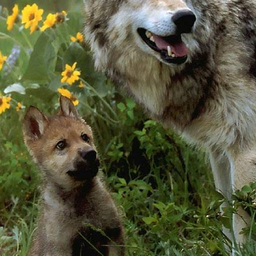

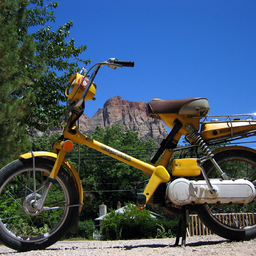

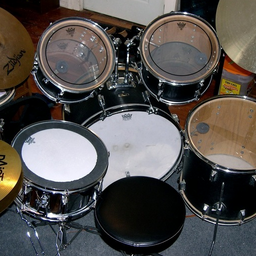

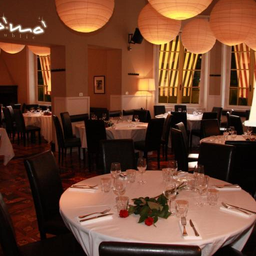

In [2]:
device = "cuda:4"
train_dataset = load_dataset("danjacobellis/LSDIR_540", split="train")
valid_dataset = load_dataset("danjacobellis/imagenet_hq", split="validation")

def collate_fn(batch):
    return torch.cat([
        PILToTensor()(RandomCrop(256)(sample['image'])).unsqueeze(0) for sample in batch
    ])

dataloader_valid = torch.utils.data.DataLoader(
    valid_dataset.select([1,7,30,33]),
    batch_size=4,
    num_workers=12,
    drop_last=True,
    shuffle=False,
    collate_fn=collate_fn
)

valid_batch = next(iter(dataloader_valid))
valid_batch = valid_batch/255
valid_batch = valid_batch - 0.5
valid_batch = valid_batch.to(device)

for img in valid_batch:
    display(ToPILImage()(img+0.5))

In [3]:
class Args:
    def __init__(self):
        self.batch_size = 64
        self.grad_accum_steps = 1
        self.plot_update = 32
        self.min_lr = 1e-7
        self.max_lr = 2e-5
        self.warmup_steps = 2000
        self.weight_decay = 0.
        self.epochs = 800
        self.channels=3
        self.J = 3
        self.N = 512
        self.latent_dim = 16
        self.num_workers = 12
        self.patience = 128
        self.ϕ = 0.01
args = Args()

In [4]:
import torch
import torch.nn as nn
import numpy as np
import einops
from pytorch_wavelets import DWTForward, DWTInverse
import diffusers.models.autoencoders as autoencoders 

class Round(nn.Module):
    def __init__(self):
        super(Round, self).__init__()
    def forward(self, x):
        if self.training:
            noise = torch.rand_like(x) - 0.5
            return x + noise
        else:
            return torch.round(x)
        
class Walloc(nn.Module):
    def __init__(self, channels, J, N, latent_dim):
        super().__init__()
        self.channels = channels
        self.J = J
        self.freq_bands = 4**J
        self.N = N
        self.latent_dim = latent_dim
        self.wt  = DWTForward(J=1, mode='periodization', wave='bior4.4')
        self.iwt = DWTInverse(mode='periodization', wave='bior4.4')
        self.clamp = torch.nn.Hardtanh(min_val=-0.5, max_val=0.5)
        self.encoder = nn.Sequential(
            autoencoders.autoencoder_kl.Encoder(
                in_channels = self.channels*self.freq_bands,
                out_channels = self.latent_dim,
                down_block_types = ('DownEncoderBlock2D',),
                block_out_channels = (N,),
                layers_per_block = 2,
                norm_num_groups = 32,
                act_fn = 'silu',
                double_z = False,
                mid_block_add_attention=True,
            ),
            torch.nn.Hardtanh(min_val=-15.499, max_val=15.499),
            Round()
        )
        self.decoder = nn.Sequential(
                autoencoders.autoencoder_kl.Decoder(
                    in_channels = self.latent_dim,
                    out_channels = self.channels*self.freq_bands,
                    up_block_types = ('UpDecoderBlock2D',),
                    block_out_channels = (N,),
                    layers_per_block = 2,
                    norm_num_groups = 32,
                    act_fn = 'silu',
                    mid_block_add_attention=True,
                ),
            )
        
    def analysis_one_level(self,x):
        L, H = self.wt(x)
        X = torch.cat([L.unsqueeze(2),H[0]],dim=2)
        X = einops.rearrange(X, 'b c f h w -> b (c f) h w')
        return X
    
    def wavelet_analysis(self,x,J=3):
        for _ in range(J):
            x = self.analysis_one_level(x)
        return x
    
    def synthesis_one_level(self,X):
        X = einops.rearrange(X, 'b (c f) h w -> b c f h w', f=4)
        L, H = torch.split(X, [1, 3], dim=2)
        L = L.squeeze(2)
        H = [H]
        y = self.iwt((L, H))
        return y
    
    def wavelet_synthesis(self,x,J=3):
        for _ in range(J):
            x = self.synthesis_one_level(x)
        return x
            
    def forward(self, x):
        X = self.wavelet_analysis(x,J=self.J)
        Y = self.encoder(X)
        X_hat = self.decoder(Y)
        x_hat = self.wavelet_synthesis(X_hat,J=self.J)
        tf_loss = F.mse_loss( X.flatten(2).norm(dim=2), X_hat.flatten(2).norm(dim=2) )
        return self.clamp(x_hat), F.mse_loss(x,x_hat), tf_loss

In [5]:
codec = Walloc(
    channels=args.channels,
    J=args.J,
    N=args.N,
    latent_dim=args.latent_dim,
).to(device)

optimizer = torch.optim.AdamW(
    params=codec.parameters(),
    weight_decay=0.0,
    lr = args.min_lr
)

sum(p.numel() for p in codec.parameters())/1e6

46.51848

In [6]:
def minus_cosine_warmup(i_step):
    scale = 0.5 * (np.log10(args.max_lr) - np.log10(args.min_lr))
    angle =  np.pi * i_step / (args.warmup_steps//args.plot_update)
    log_lr = np.log10(args.min_lr) + scale * (1 - np.cos(angle))
    lr = 10 ** log_lr
    return lr/args.min_lr
    
warmup = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda = lambda i_step: minus_cosine_warmup(i_step)
)

reduce_plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.98,
    patience=args.patience,
    threshold=1e-5,
    min_lr=args.min_lr
)

In [ ]:
warnings.filterwarnings("ignore", message="Truncated File Read", category=UserWarning, module="PIL.TiffImagePlugin")
dist_losses, rate_losses = [], []
learning_rates = [optimizer.param_groups[0]['lr']]
img_displays = []
text_display = None
codec.train()
optimizer.zero_grad()
mb = master_bar(range(args.epochs))
mb.names = ['Distortion Loss', 'Smoothed']
i_step = 0
for i_epoch in mb:
    dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=args.batch_size,
        num_workers=args.num_workers,
        drop_last=True,
        shuffle=True,
        collate_fn=collate_fn
    )
   
    for i, batch in enumerate(progress_bar(dataloader, parent=mb)):
    
        x = batch.to(device)
        x = x.to(torch.float)
        x = x/255
        x = x-0.5

        _, mse_loss, tf_loss = codec(x)

        dist_loss = mse_loss + args.ϕ*tf_loss
        dist_losses.append(np.log10(dist_loss.item()))
        loss = dist_loss
        loss.backward()
        if (i + 1) % args.grad_accum_steps == 0: 
            optimizer.step()
            optimizer.zero_grad()
        
        # plotting and lr scheduler
        if len(dist_losses) % args.plot_update == 0:
            plot_n = len(dist_losses) // args.plot_update
            smoothed_x = (0.5+torch.arange(plot_n)) * args.plot_update
            smoothed_y = torch.tensor(dist_losses).reshape(plot_n, -1).mean(dim=1)
            dist_x = range(len(dist_losses))
            dist_y = dist_losses
            mb.update_graph([[dist_x, dist_y],[smoothed_x, smoothed_y]])
            mb.child.comment = f'loss {smoothed_y[-1]:.4g}; lr {learning_rates[-1]:.4g}'

            # lr scheduler
            if i_step < args.warmup_steps:
                warmup.step()
            else:
                reduce_plateau.step(smoothed_y[-1])
            learning_rates.append(optimizer.param_groups[0]['lr'])

            with torch.no_grad():
                codec.eval()
                y_valid, _, _ = codec(valid_batch)
                codec.train()
            
            for img_idx, img in enumerate(y_valid):
                buffer = io.BytesIO()
                ToPILImage()(img + 0.5).save(buffer, format="PNG")
                # ToPILImage()(img + 0.5).save(f"video/{img_idx}_{i_epoch}_{i}.png")
                buffer.seek(0)
                if len(img_displays) <= img_idx:
                    img_displays.append(display(Image(buffer.read()), display_id=True))
                else:
                    update_display(Image(buffer.read()), display_id=img_displays[img_idx].display_id)
        i_step+=1
        
    if (i_epoch + 1) % 20 == 0: 
        torch.save({
            'model_state_dict': codec.state_dict(),
            'i_epoch': i_epoch,
            'learning_rates': learning_rates,
            'dist_losses': dist_losses,
            'args': args
        }, f"walloc_e{i_epoch+1}_4.pth")

In [8]:
import matplotlib.pyplot as plt
display(HTML(mb.main_bar.progress))
display(HTML(mb.child.progress))

In [11]:
torch.save({
    'model_state_dict': codec.state_dict(),
    'i_epoch': i_epoch,
    'learning_rates': learning_rates,
    'dist_losses': dist_losses,
    'args': args
}, "../../hf/walloc/v0.5.4.pth")

(-2.65, -2.25)

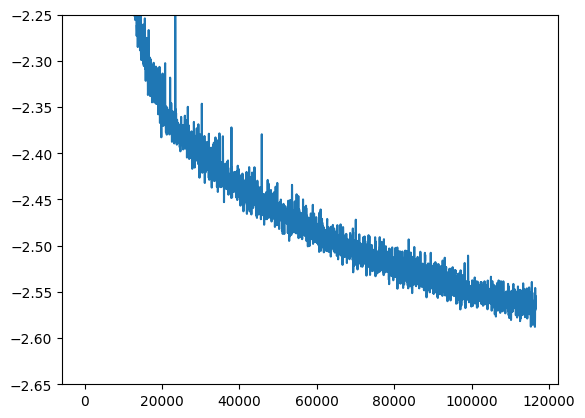

In [10]:
plt.plot(smoothed_x,smoothed_y)
plt.ylim([-2.65,-2.25])

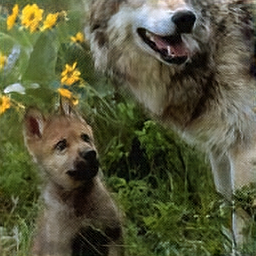

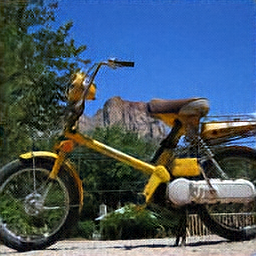

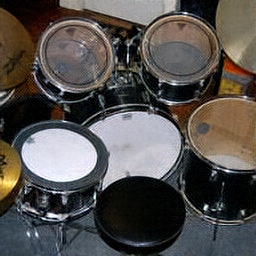

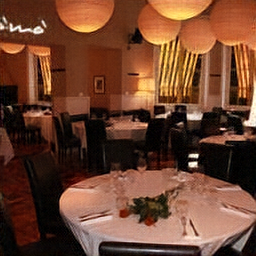

In [12]:
for img_idx, img in enumerate(y_valid):
    display(ToPILImage()(img + 0.5))

In [13]:
with torch.no_grad():
    X = codec.wavelet_analysis(valid_batch,codec.J)
    Z = codec.encoder(X)

In [14]:
import zlib
bytes = Z.round().to(torch.int8).detach().cpu().numpy().tobytes()
print(valid_batch.numel()/len(bytes))
print(valid_batch.numel()/len(zlib.compress(bytes,level=9)))

12.0
20.781439103665143


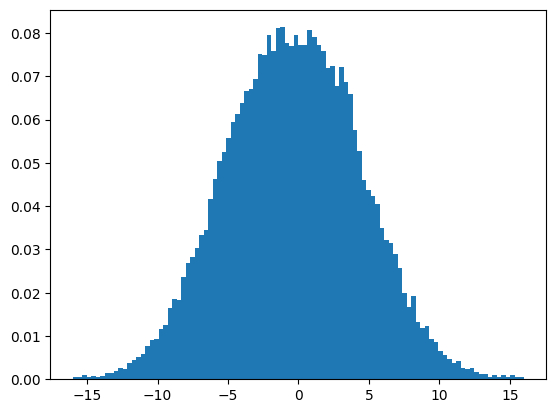

In [16]:
plt.hist(Z.to("cpu").flatten().numpy(), density=True,range=(-16,16),bins=100);